In [1]:
import pydotplus 
import pandas as pd
import numpy as np
import StringIO

#from PIL import Image, ImageDraw
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn import tree, datasets
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

%matplotlib inline

## 1. Теоретические задачи

### 1.1 Ответы в листьях регрессионного дерева

### 1.2 Линейные модели в деревьях

### 1.3 Unsupervised decision tree

## 2. Применение решающего дерева

#### 20% баллов за задание, оценочное время выполнения 30 минут + установка GraphViz

Постройте решающее дерево из sklearn на датасете german credit data из UCI репозитория и визуализируйте его. Попробуйте проинтерпретировать первые несколько разбиений, изучив описание признаков. Постройте графики зависимости качества на кросс-валидации и на обучающей выборке от глубины дерева

In [34]:
#загружаем данные
data = pd.read_csv('german-numeric.csv', sep=',', header = -1)
train_data, test_data, train_target, test_target = train_test_split(data.iloc[:, :-1], data[24], test_size = 0.2)

In [35]:
data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2
5,4,36,2,91,5,3,3,4,4,35,...,0,0,1,0,0,0,0,1,0,1
6,4,24,2,28,3,5,3,4,2,53,...,0,0,1,0,0,1,0,0,1,1
7,2,36,2,69,1,3,3,2,3,35,...,0,1,1,0,1,0,0,0,0,1
8,4,12,2,31,4,4,1,4,1,61,...,0,0,1,0,0,1,0,1,0,1
9,2,30,4,52,1,1,4,2,3,28,...,1,0,1,0,0,1,0,0,0,2


In [36]:
#строим решающее дерево
tr = tree.DecisionTreeClassifier(max_depth=4)
tr.fit(data.iloc[:, :-1], data[24]);

In [37]:
dot_data = tree.export_graphviz(tr, out_file="tree.out", 
                         feature_names=data.columns,  
                         class_names=['1', '2'],  
                         filled=True, rounded=True,  
                         special_characters=True)  

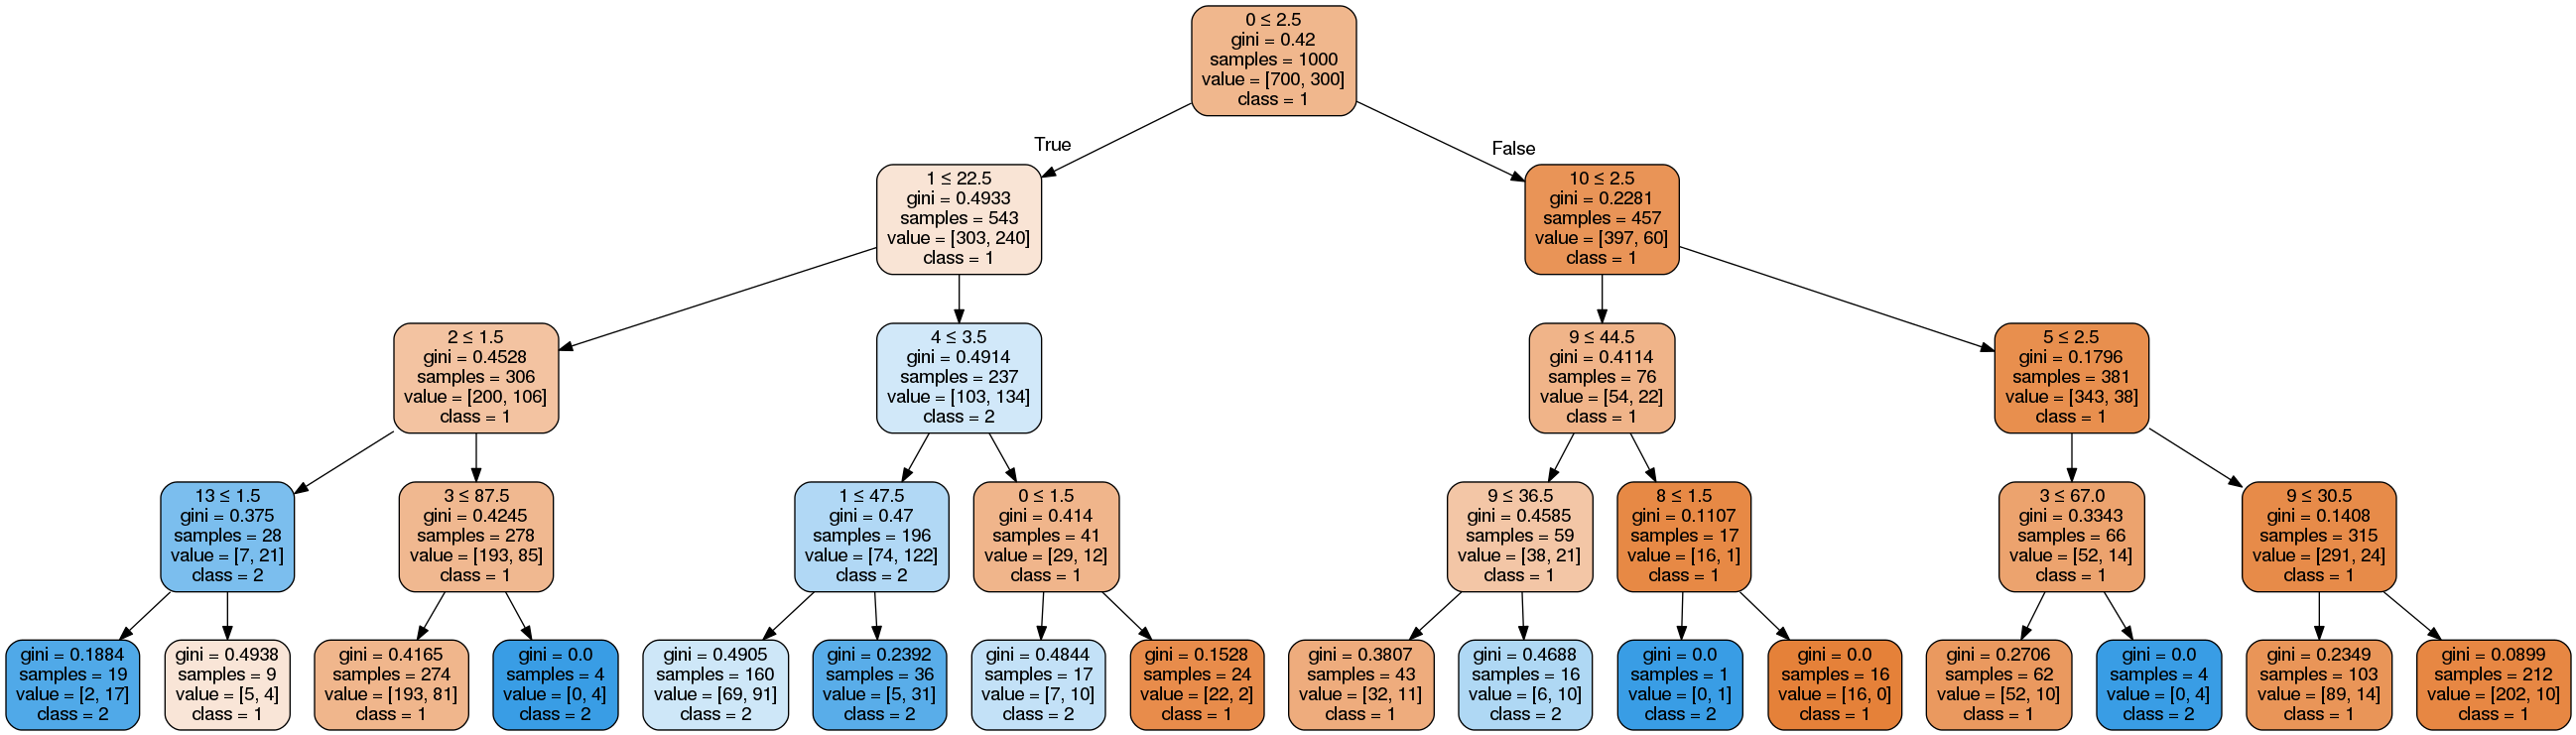

In [38]:
#строим и сохраняем визуализированное дерево
graph = pydotplus.graphviz.graph_from_dot_file("tree.out")
Image(graph.create_png())  
#im = Image.open(StringIO.StringIO(graph.create_png()))
#im.save('tree.png')
#im.format = "PNG"
#im.show()

In [39]:
#проводим кросс-валидацию и получаем предсказания на тестовой подвыборке
res_cv=[]
res_train=[]
for i in range(1, 30):
    tr = tree.DecisionTreeClassifier(max_depth=i)
    
    cv = cross_val_score(tr, data.iloc[:, :-1], data[24], cv=5, scoring='accuracy')
    res_cv.append((i, cv.mean()))
    
    tr.fit(train_data, train_target)
    test_predictions = tr.predict(test_data)
    res_train.append((i,accuracy_score(test_target, test_predictions)))

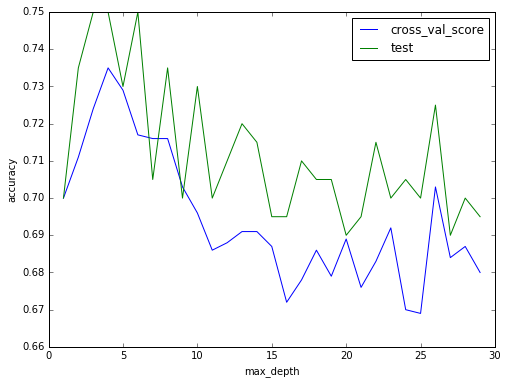

In [40]:
plt.figure(figsize=(8,6))
plt.plot(map(lambda x: x[0], res_cv), map(lambda x: x[1], res_cv), label='cross_val_score')
plt.plot(map(lambda x: x[0], res_train), map(lambda x: x[1], res_train), label='test')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

## 3. Реализация решающего дерева

#### 50% баллов за задание, оценочное время выполнения 3-4 часа

В этом задании предлагается использовать датасет boston из sklearn.datasets. Оставьте
последние 25% объектов для контроля качества, разделив X и y на X_train, y_train и X_test,
y_test.

Реализуйте свой класс DecisionTree, имеющий методы fit и predict, позволяющие соответ-
ственно обучить решающее дерево по матрице признаков X_train и ответам y_train, а затем
спрогнозировать ответы на тестовой выборке X_test. Оцените качество работы вашего дерева
на тестовой выборке.

Рекомендации по реализации дерева:
1. Обучение дерева можно реализовать простым жадным рекурсивным алгоритмом - каждый раз выбирайте наилучшее разбиение (номер признака и порог по нему) по уместному на ваш взгляд критерию из рассмотренных на первой лекции о решающих деревьях (MSE, gini, энтропийный критерий, ошибка классификации)
2. Выбор наилучшего разбиения можно сделать простым перебором по признакам и порогам.
3. Пороги можно перебирать из заранее заданного множества порогов на обучающей выборке - например, взяв все пороги между принимаемыми значениями координат, либо взяв случайный набор порогов, либо взяв пороги по квантилям значений каждого признака (посчитать квантили будет несложно с помощью scipy). Если возможных порогов будет слишком много, выбор наилучшего разбиения может оказаться слишком долгой операцией.
4. Сделайте возможным передавать в конструктор класса ограничение по глубине дерева и заканчивайте построение дерева при достижении этого ограничения.
5. Можно реализовать отдельный класс для решающего правила вида "k-ый признак меньше порога" и отдельный класс для дерева. Также вам предстоит подумать, как хранить разбиения внутри дерева, чтобы их было удобно использовать.
6. Какие-то из решений вы можете подсмотреть в чужих реализациях дерева, но от вас не требуется написать применимую на практике библиотеку - только максимально простую демонстрацию того, как строится и применяется решающее дерево.

In [2]:
class DTree:
    data = 0
    max_depth = 0
    tree = []
    
    #инициализация
    def __init__(self, _max_depth):
        self.max_depth = _max_depth 
        
    #обучение
    def fit(self, data, target): 
        
        #среднеквадратичная ошибка
        def H(X):
            Y = X.sum() / len(X)
            return ((X - Y)**2).sum() / len(X) 
        
        #рекурсивная функция построения дерева
        def build(X, level, max_level):
            if level == max_level:
                return [('nan', 'nan', X['target'].sum() / len(X))]
            limit = (0, 0, float("inf"))
            for i in X.axes[1][:-1]:
                for p in np.linspace(X[i].min(), X[i].max(), 5):
                    Xr = X.where(X[i] >= p).dropna()
                    Xl = X.where(X[i] <= p).dropna()
                    Q = float(len(Xl)) / len(X) * H(Xl['target']) + float(len(Xr)) / len(X) * H(Xr['target'])
                    if Q < limit[2]:
                        limit = (i, p, Q)
            Xr = X.where(X[limit[0]] > limit[1]).dropna()
            Xl = X.where(X[limit[0]] <= limit[1]).dropna()
            if len(Xr) == 0 or len(Xl) == 0:
                return [('nan', 'nan', X['target'].sum() / len(X))]
            resR = build(Xr, level + 1, max_level)
            resL = build(Xl, level + 1, max_level)
            return [(limit[0], limit[1], len(resL)+1)] + resL + resR 
        
        data = pd.DataFrame(data)
        target = pd.DataFrame(target)
        data['target']= target
        self.tree = build(data, 1, self.max_depth)
    
    #предсказание
    def predict(self, data):
        
        #предсказание для одного элемента
        def predict_one(x, tree):
            iter = 0;
            while 1:
                if tree[iter][0] == 'nan':
                    return tree[iter][2]
                if x.iloc[tree[iter][0]] <= tree[iter][1]:
                    iter = iter + 1
                else:
                    iter = iter + tree[iter][2]
        
        data = pd.DataFrame(data)
        res = []
        for i in xrange(0, data.shape[0]):
            res.append(predict_one(data.iloc[i], self.tree))
        return res

In [3]:
data = datasets.load_boston()

In [4]:
train_data, test_data, train_target, test_target = train_test_split(data['data'], data['target'], test_size = 0.25)

In [5]:
test_target

array([ 12.5,  27.5,  19.6,  33.3,  15.6,   8.3,  22. ,  14.4,  21.1,
        19.4,  31.2,  32.5,  19.4,  15.4,  17.5,  18. ,  21.9,  12.3,
        10.9,  17.9,  21.4,  23.8,  24.1,  28.7,  27. ,  17.4,  24.7,
        23.5,  18.8,  13.3,  31.7,  22.5,  24.4,  23.9,  21.7,  13.6,
        20. ,  19.2,  22.6,  22.9,  22.2,  23.1,  25. ,  20.3,  48.8,
        19.1,  21.2,  28. ,  22.2,  19.1,   8.3,  13.8,  24. ,  20.1,
        30.1,  13.6,  22. ,  10.2,  20.2,  19.3,  29. ,  14.9,  18.6,
        24.3,  23.3,  18.1,  37.6,  34.9,  13. ,  28.7,  10.9,  21.8,
        50. ,  20.9,  20. ,  34.9,  27.9,  10.8,  11.7,  18.8,   7.2,
        18.4,  20. ,  22.3,  27.5,  20.4,  15.3,  36. ,  10.5,  22.9,
        16.5,  37.2,  18.7,  20.1,  19. ,  24.1,  19.7,  23.4,  12.8,
        22.1,  20.4,  39.8,  23.8,  19.6,   9.5,  16.1,  14.3,  20.1,
        21.7,  17. ,  16.6,  24.7,  50. ,  21. ,  26.7,  13.3,  20.4,
        33.2,  23.6,  19.1,  23.6,  11.9,  24.4,  18.4,  29.8,  15.7,  17.6])

In [6]:
#проводим кросс-валидацию и получаем предсказания на тестовой подвыборке
res_train_1=[]
res_train_2=[]
for i in xrange(1, 7):
    tr1 = DTree(i)
    tr2 = tree.DecisionTreeRegressor(max_depth=i)
    
    tr1.fit(train_data, train_target)
    test_predictions_1 = tr1.predict(test_data)
    res_train_1.append((i,mean_squared_error(test_target, test_predictions_1)))
    
    tr2.fit(train_data, train_target)
    test_predictions_2 = tr2.predict(test_data)
    res_train_2.append((i,mean_squared_error(test_target, test_predictions_2)))

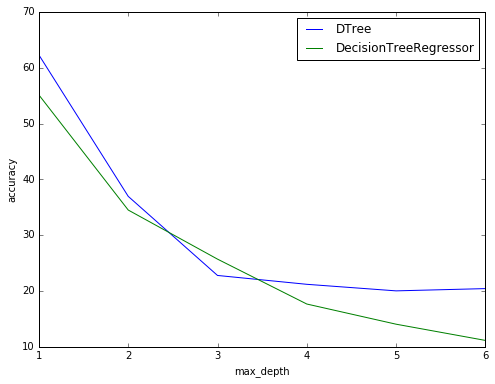

In [7]:
plt.figure(figsize=(8,6))
plt.plot(map(lambda x: x[0], res_train_1), map(lambda x: x[1], res_train_1), label='DTree')
plt.plot(map(lambda x: x[0], res_train_2), map(lambda x: x[1], res_train_2), label='DecisionTreeRegressor')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()